# 1. Assumption/Objective -> พี่เอื้อย, พี่เปิ้ล

# 2. Exploratory Data Analysis (EDA)


  - Main Experiment 
    - EDA อธิบายทุกอย่างที่เจอมาใน Data -> คิมฮ้อ
    - Data การจัด Data (แบบใส่ gender และไม่ใส่ Gender) -> คิมฮ้อ
      - Distribution ก่อนทำ Gender -> คิมฮ้อ
      - Gender Classification -> Data, model, post process, evaluation
      - Distribution หลังทำ Gender -> คิมฮ้อ
    - Model  (แบบใส่ gender และไม่ใส่ Gender) -> ฟ้า
  -Results -> Main Experiment แบบใส่ gender และไม่ใส่ Gender -> ฟ้า, และคนอื่น ๆ
  ------------------------------------------------------------

 

 We explored the validated data of commonvoice11 data and found that the data contains 135,897 samples, some samples have no information on gender and the distribution of gender is not equal. The gender label is very important for handling the bias between gender. The distribution of data is shown below.

In [2]:
import pandas as pd
df_all_data = pd.read_csv("data/annotation/validated.tsv", sep='\t')

/Users/kongpolc/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
rm_dp_df_all = df_all_data.drop_duplicates(subset=["sentence", "client_id"], keep="first") #Duplicate removal: same person should not speak same sentence.
print("no all data:",len(rm_dp_df_all))

rm_dp_df_all[['gender']] = rm_dp_df_all[['gender']].fillna(value="not_filling")

print("no gender data:\n", rm_dp_df_all["gender"].value_counts())

no all data: 135897
no gender data:
 male           52769
not_filling    51024
female         30283
other           1821
Name: gender, dtype: int64


As shown above, the data have the majority to the male gender. Therfore, we decided to divide the data into 3 datasets since we assumed this data should be made biased toward a male voice more than a female voice. The details of each data are below.
1. Dataset 1: Split data to train, dev, and test by the ratio of data will be the same as a whole validated data. [original ratio]
2. Dataset 2: We use the output data from the First data to balance the gender in train data, dev, and test. We consider only male and female because we do not know the exact gender of "other" and "not_filling" classes.
3. Third data: We use the output data from the Second data to balance gender and made equality between males and females. By in each sentence of each data will be spoken only by 1 male and 1 female. We consider only male and female because we do not know the exact gender of "other" and "not_filling" classes.

In [4]:
# get the whole data ration

male_ratio = len(rm_dp_df_all[rm_dp_df_all["gender"] == "male"])/len(rm_dp_df_all)
female_ratio = len(rm_dp_df_all[rm_dp_df_all["gender"] == "female"])/len(rm_dp_df_all)
other_ratio = len(rm_dp_df_all[rm_dp_df_all["gender"] == "other"])/len(rm_dp_df_all)
not_filling_ratio = len(rm_dp_df_all[rm_dp_df_all["gender"] == "not_filling"])/len(rm_dp_df_all)
print("no gender ratio:", sum([male_ratio, female_ratio, other_ratio, not_filling_ratio]))
print("male ratio:",  male_ratio)
print("female ratio:", female_ratio)
print("other ratio:", other_ratio)
print("not_filling ratio:", not_filling_ratio)

no gender ratio: 1.0
male ratio: 0.3883014341744115
female ratio: 0.22283788457434675
other ratio: 0.013399854301419458
not_filling ratio: 0.3754608269498223


# 3. Data Preparation

In [48]:
# setting data ratio
train_ratio = 0.85
dev_ratio = 0.05
test_ratio = 0.1

### 3.1 First data set seperation

In [49]:
def seperator(total_ratio, class_ratio, df_all): # seperator function, this function can separate data with group data ratio.
    no_total = total_ratio*len(rm_dp_df_all)

    all_df_class_list = []
    df_the_rest =  df_all
    for key in class_ratio:
        no_each_class = int(class_ratio[key]*no_total)
        
        df_tmp = df_the_rest[df_the_rest["gender"]==key]
        df_tmp = df_the_rest.sample(n=no_each_class, random_state=47, replace=False)
        df_the_rest = pd.concat([df_the_rest, df_tmp]).drop_duplicates(subset=["sentence", "client_id"], keep=False)
        
        all_df_class_list.append(df_tmp)
    df_out_data = pd.concat(all_df_class_list)
        
    return df_out_data, df_the_rest

In [50]:
# train seperation
df_train, df_the_rest_sofar = seperator(train_ratio, {'male': male_ratio, 'female': female_ratio, 'other': other_ratio, 'not_filling': not_filling_ratio},rm_dp_df_all)
# dev seperation
df_dev, df_the_rest_sofar = seperator(dev_ratio, {'male': male_ratio, 'female': female_ratio, 'other': other_ratio, 'not_filling': not_filling_ratio},df_the_rest_sofar)
# test seperation
df_test, df_the_rest_sofar = seperator(test_ratio, {'male': male_ratio, 'female': female_ratio, 'other': other_ratio, 'not_filling': not_filling_ratio},df_the_rest_sofar)


In [51]:
print("Actual no data: ")
print("Train:", len(df_train))
print(df_train["gender"].value_counts())
print("Dev:", len(df_dev))
print(df_dev["gender"].value_counts())
print("Test:", len(df_test))
print(df_test["gender"].value_counts())

Actual no data: 
Train: 115510
male           44821
not_filling    43326
female         25825
other           1538
Name: gender, dtype: int64
Dev: 6794
male           2625
not_filling    2567
female         1517
other            85
Name: gender, dtype: int64
Test: 13588
male           5322
not_filling    5130
female         2938
other           198
Name: gender, dtype: int64


In [9]:
# export the first data set
df_train.to_csv("data/annotation/dataset_1/train.csv", index=False)
df_dev.to_csv("data/annotation/dataset_1/dev.csv", index=False)
df_test.to_csv("data/annotation/dataset_1/test.csv", index=False)

### 3.2 Second data set seperation

In [10]:
# Read the first data set
df_normal_train = pd.read_csv("data/annotation/dataset_1/train.csv")
df_normal_dev = pd.read_csv("data/annotation/dataset_1/dev.csv")
df_normal_test = pd.read_csv("data/annotation/dataset_1/test.csv")

In [14]:
# keeping data only male and female
df_balance_train = df_normal_train[df_normal_train["gender"]!="not_filling"]
df_balance_train = df_balance_train[df_balance_train["gender"]!="other"]

df_balance_dev = df_normal_dev[df_normal_dev["gender"]!="not_filling"]
df_balance_dev = df_balance_dev[df_balance_dev["gender"]!="other"]

df_balance_test = df_normal_test[df_normal_test["gender"]!="not_filling"]
df_balance_test = df_balance_test[df_balance_test["gender"]!="other"]

In [15]:
# distribution after remove not gender filling and other
display(df_balance_train["gender"].value_counts())
display(df_balance_dev["gender"].value_counts())
display(df_balance_test["gender"].value_counts())

male      44821
female    25825
Name: gender, dtype: int64

male      2625
female    1517
Name: gender, dtype: int64

male      5322
female    2938
Name: gender, dtype: int64

In [16]:
# Sampling balance train data
no_female_in_train = len(df_balance_train[df_balance_train["gender"] =="female"])

df_female_train = df_balance_train[df_balance_train["gender"]=="female"]
df_male_train = df_balance_train[df_balance_train["gender"]=="male"].sample(frac=1, replace=False, random_state=47)
df_male_train.reset_index(inplace = True, drop=True)
df_male_train = df_male_train[0:no_female_in_train]

df_out_balance_train = pd.concat([df_male_train, df_female_train])
df_out_balance_train["gender"].value_counts()

male      25825
female    25825
Name: gender, dtype: int64

In [17]:
# Sampling balance test data
no_female_in_test = len(df_balance_test[df_balance_test["gender"] =="female"])
df_female_test = df_balance_test[df_balance_test["gender"]=="female"]
df_male_test = df_balance_test[df_balance_test["gender"]=="male"].sample(frac=1, replace=False, random_state=47)
df_male_test.reset_index(inplace = True, drop=True)
df_male_test = df_male_test[0:no_female_in_test]

df_out_balance_test = pd.concat([df_male_test, df_female_test])
df_out_balance_test["gender"].value_counts()

male      2938
female    2938
Name: gender, dtype: int64

In [18]:
# Sampling balance dev data
no_female_in_dev = len(df_balance_dev[df_balance_dev["gender"] =="female"])

df_female_dev = df_balance_dev[df_balance_dev["gender"]=="female"]
df_male_dev = df_balance_dev[df_balance_dev["gender"]=="male"].sample(frac=1, replace=False, random_state=47)
df_male_dev.reset_index(inplace = True, drop=True)
df_male_dev = df_male_dev[0:no_female_in_dev]

df_out_balance_dev = pd.concat([df_male_dev, df_female_dev])
df_out_balance_dev["gender"].value_counts()

male      1517
female    1517
Name: gender, dtype: int64

In [19]:
# distribution of second data set
display(df_out_balance_train["gender"].value_counts())
display(df_out_balance_dev["gender"].value_counts())
display(df_out_balance_test["gender"].value_counts())

male      25825
female    25825
Name: gender, dtype: int64

male      1517
female    1517
Name: gender, dtype: int64

male      2938
female    2938
Name: gender, dtype: int64

In [20]:
# export second data set
df_out_balance_train.to_csv("data/annotation/dataset_2/train.csv", index=False)
df_out_balance_dev.to_csv("data/annotation/dataset_2/dev.csv", index=False)
df_out_balance_test.to_csv("data/annotation/dataset_2/test.csv", index=False)

### 3.3 Third data seperation

In [38]:
# Read second data set
df_normal_train = pd.read_csv("data/annotation/dataset_1/train.csv")
df_normal_dev = pd.read_csv("data/annotation/dataset_1/dev.csv")
df_normal_test = pd.read_csv("data/annotation/dataset_1/test.csv")

In [40]:
# keeping data only male and female
df_balance_same_train = df_normal_train[df_normal_train["gender"]!="not_filling"]
df_balance_same_train = df_balance_same_train[df_balance_same_train["gender"]!="other"]

df_balance_same_dev = df_normal_dev[df_normal_dev["gender"]!="not_filling"]
df_balance_same_dev = df_balance_same_dev[df_balance_same_dev["gender"]!="other"]

df_balance_same_test = df_normal_test[df_normal_test["gender"]!="not_filling"]
df_balance_same_test = df_balance_same_test[df_balance_same_test["gender"]!="other"]

In [42]:
# sampling balance train data and same sentence
df_balance_same_train["duplicated"] = df_balance_same_train.duplicated(subset=["sentence"], keep=False) # duplicate with 2 conditions
df_balance_same_train = df_balance_same_train[df_balance_same_train["duplicated"] == True]

df_balance_male_train = df_balance_same_train[df_balance_same_train["gender"] == "male"]
df_balance_female_train = df_balance_same_train[df_balance_same_train["gender"] == "female"]


df_balance_male_train.drop_duplicates(subset=["sentence"], keep="first", inplace=True)
df_balance_female_train.drop_duplicates(subset=["sentence"], keep="first", inplace=True)

df_balance_male_train = df_balance_male_train[df_balance_male_train["sentence"].isin(df_balance_female_train["sentence"])]
df_balance_female_train = df_balance_female_train[df_balance_female_train["sentence"].isin(df_balance_male_train["sentence"])]

df_balance_all_train = pd.concat([df_balance_male_train, df_balance_female_train])

df_balance_all_train.to_csv("data/annotation/dataset_3/train.csv", index=False)

print(df_balance_all_train["gender"].value_counts())

/Users/kongpolc/opt/anaconda3/envs/stt/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


male      12149
female    12149
Name: gender, dtype: int64


In [44]:
# sampling balance dev data and same sentence
df_balance_same_dev["duplicated"] = df_balance_same_dev.duplicated(subset=["sentence"], keep=False) # duplicate with 2 conditions
df_balance_same_dev = df_balance_same_dev[df_balance_same_dev["duplicated"] == True]

df_balance_male_dev = df_balance_same_dev[df_balance_same_dev["gender"] == "male"]
df_balance_female_dev = df_balance_same_dev[df_balance_same_dev["gender"] == "female"]


df_balance_male_dev.drop_duplicates(subset=["sentence"], keep="first", inplace=True)
df_balance_female_dev.drop_duplicates(subset=["sentence"], keep="first", inplace=True)

df_balance_male_dev = df_balance_male_dev[df_balance_male_dev["sentence"].isin(df_balance_female_dev["sentence"])]
df_balance_female_dev = df_balance_female_dev[df_balance_female_dev["sentence"].isin(df_balance_male_dev["sentence"])]

df_balance_all_dev = pd.concat([df_balance_male_dev, df_balance_female_dev])

df_balance_all_dev.to_csv("data/annotation/dataset_3/dev.csv", index=False)

print(df_balance_all_dev["gender"].value_counts())

male      74
female    74
Name: gender, dtype: int64


/Users/kongpolc/opt/anaconda3/envs/stt/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [45]:
# sampling balance test data
df_balance_same_test["duplicated"] = df_balance_same_test.duplicated(subset=["sentence"], keep=False) # duplicate with 2 conditions
df_balance_same_test = df_balance_same_test[df_balance_same_test["duplicated"] == True]

df_balance_male_test = df_balance_same_test[df_balance_same_test["gender"] == "male"]
df_balance_female_test = df_balance_same_test[df_balance_same_test["gender"] == "female"]


df_balance_male_test.drop_duplicates(subset=["sentence"], keep="first", inplace=True)
df_balance_female_test.drop_duplicates(subset=["sentence"], keep="first", inplace=True)

df_balance_male_test = df_balance_male_test[df_balance_male_test["sentence"].isin(df_balance_female_test["sentence"])]
df_balance_female_test = df_balance_female_test[df_balance_female_test["sentence"].isin(df_balance_male_test["sentence"])]

df_balance_all_test = pd.concat([df_balance_male_test, df_balance_female_test])

df_balance_all_test.to_csv("data/annotation/dataset_3/test.csv", index=False)

print(df_balance_all_test["gender"].value_counts())

male      203
female    203
Name: gender, dtype: int64


In [46]:
# distribution of third data set
display(df_balance_all_train["gender"].value_counts())
display(df_balance_all_dev["gender"].value_counts())
display(df_balance_all_test["gender"].value_counts())

male      12149
female    12149
Name: gender, dtype: int64

male      74
female    74
Name: gender, dtype: int64

male      203
female    203
Name: gender, dtype: int64

### Summarize the distribution of data 1-3

In [47]:
print("Data 1 ")
print("Train:", len(df_train))
print(df_train["gender"].value_counts())
print("Dev:", len(df_dev))
print(df_dev["gender"].value_counts())
print("Test:", len(df_test))
print(df_test["gender"].value_counts())
print("----------------------------")
print("Data 2 ")
print("Train:", len(df_out_balance_train))
print(df_out_balance_train["gender"].value_counts())
print("Dev:", len(df_out_balance_dev))
print(df_out_balance_dev["gender"].value_counts())
print("Test:", len(df_out_balance_test))
print(df_out_balance_test["gender"].value_counts())
print("----------------------------")
print("Data 3 ")
print("Train:", len(df_balance_all_train))
print(df_balance_all_train["gender"].value_counts())
print("Dev:", len(df_balance_all_dev))
print(df_balance_all_dev["gender"].value_counts())
print("Test:", len(df_balance_all_test))
print(df_balance_all_test["gender"].value_counts())

Data 1 
Train: 115510
male           44821
not_filling    43326
female         25825
other           1538
Name: gender, dtype: int64
Dev: 6794
male           2625
not_filling    2567
female         1517
other            85
Name: gender, dtype: int64
Test: 13588
male           5322
not_filling    5130
female         2938
other           198
Name: gender, dtype: int64
----------------------------
Data 2 
Train: 51650
male      25825
female    25825
Name: gender, dtype: int64
Dev: 3034
male      1517
female    1517
Name: gender, dtype: int64
Test: 5876
male      2938
female    2938
Name: gender, dtype: int64
----------------------------
Data 3 
Train: 24298
male      12149
female    12149
Name: gender, dtype: int64
Dev: 148
male      74
female    74
Name: gender, dtype: int64
Test: 406
male      203
female    203
Name: gender, dtype: int64


# 4. Model and Evaluation
For this experiment, 2 models are used to prove the assumption. Firstly, speech-to-text model is used to transcribe spoken words and compare the difference in performance in male and female in the 3 datasets. Secondly, speech gender classification model is used to impute gender for dataset 2 and 3 to increase the amount of training data and, hopefully, improve WER and CER biases between genders as well as WER and CER in general.

### 4.1 Speech-To-Text Model
This section contains brief details of model, training, and evaluation. For more detail and code please see [link to path].

The code and detail for training and evaluation of this model is available at [link to path]

**Model**

Data2vec

**Training**

Train 3 models with 3 datasets described above.

- First Dataset (Original ratio)

- Second Dataset (Balance ratio between female & male)

- Third Dataset (Balance ratio between female & male with speaking same sentence)

**Evaluation**

All three models were evaluated with test set 1-3 to find insights and identify
gender bias. The metrics used are Word Error Rate (WER) and Character Error Rate (CER)

**- Word Error Rate (WER)**

Table below shows that WER of female is slightly less than male in most models and test sets.

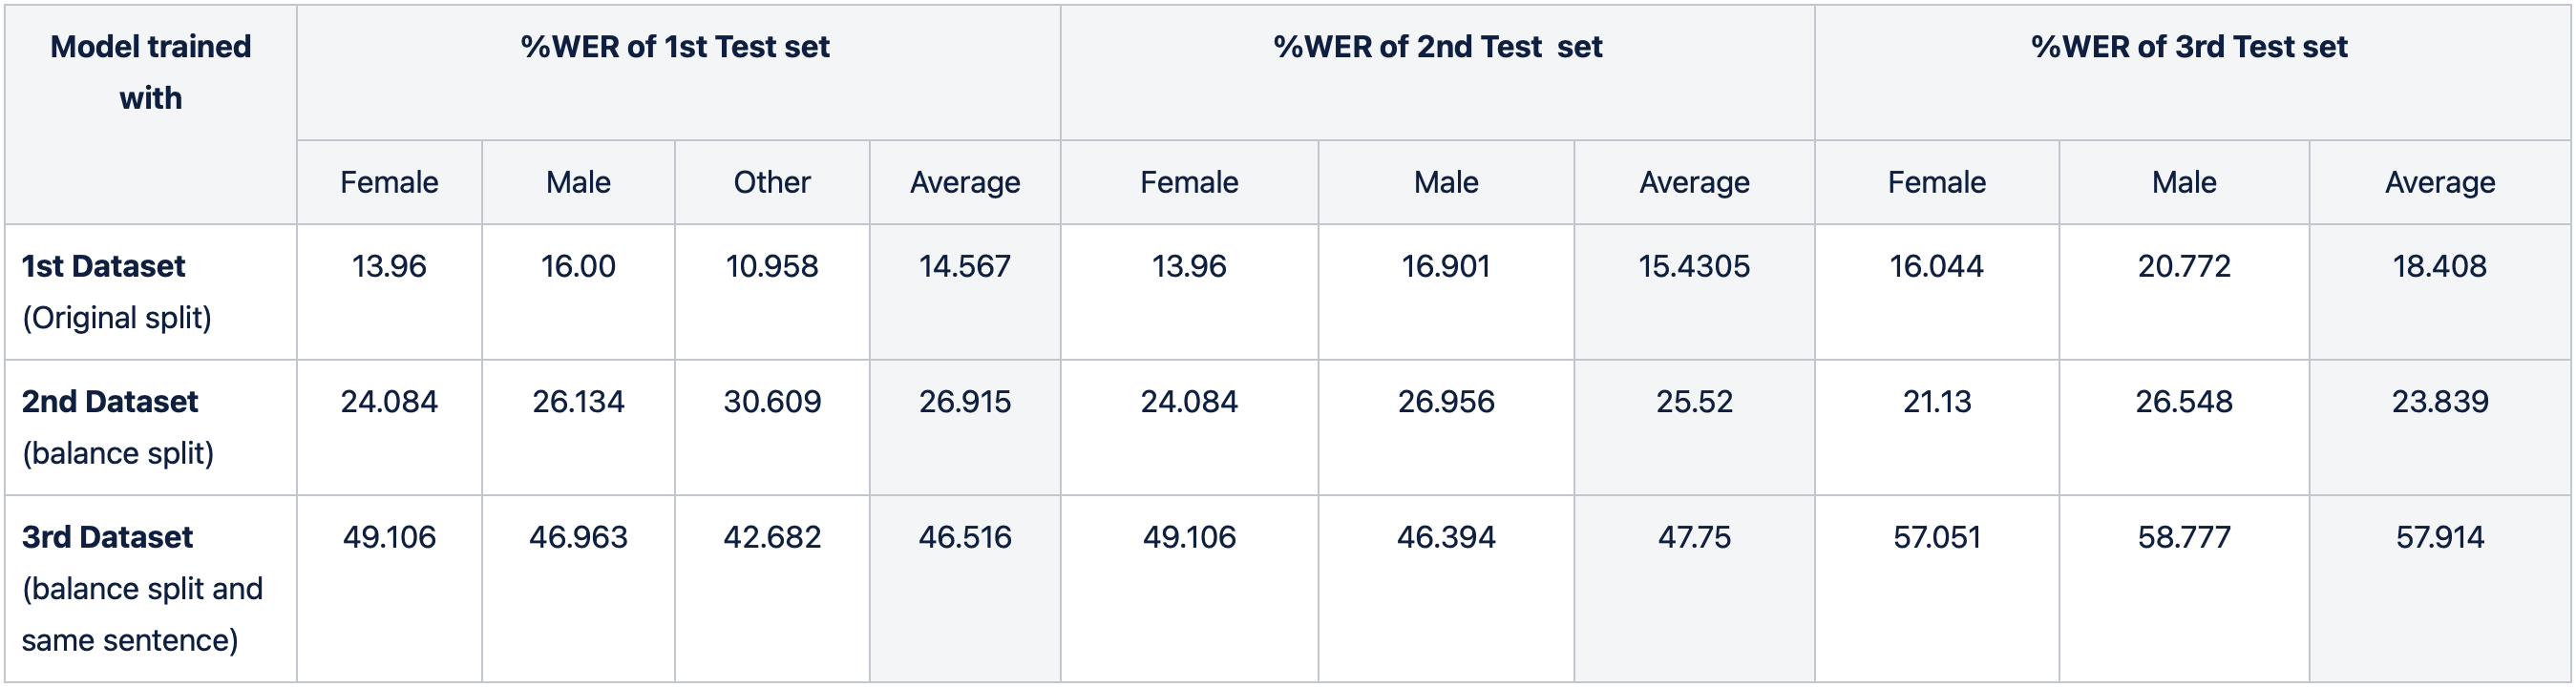

**- Character Error Rate (CER)**

Same as WER, CER of female is slightly less than that of male in every models and test sets.

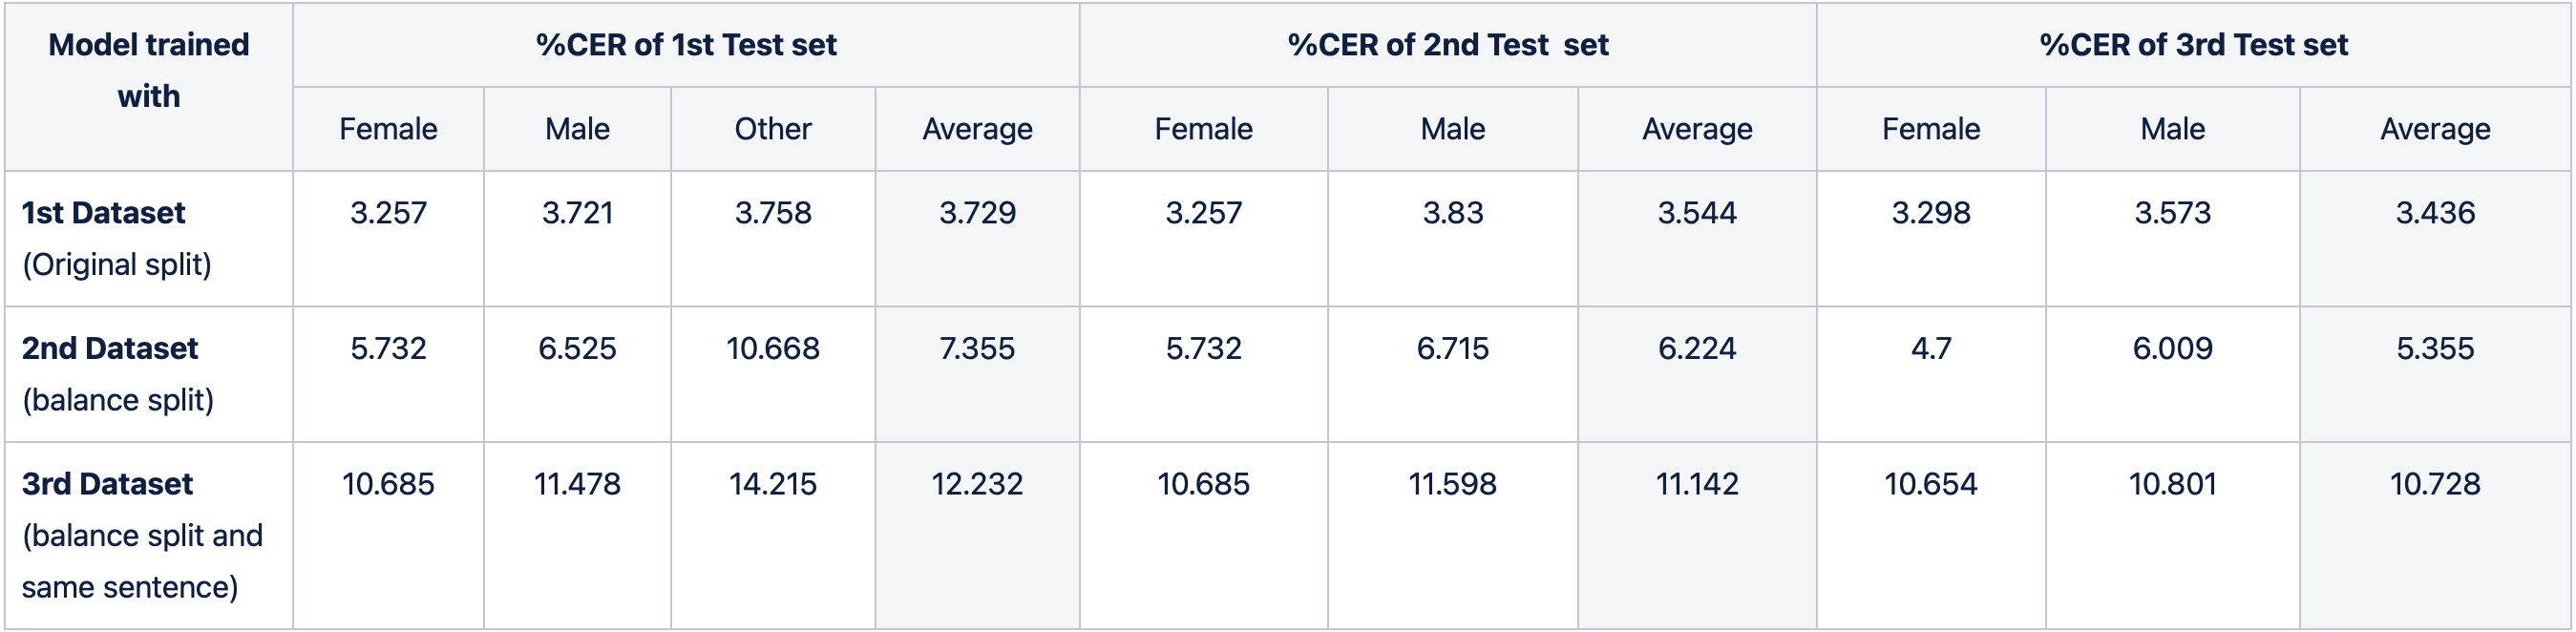

### 4.2 Speech Gender Classification Model
This section contains brief details of model, training, and evaluation. For more detail and code please see [link to path].

**Model**

Time Delay Neural Network (TDNN)

<!-- Gender classifier is simply a stack of 5 TDNN modules. Then, on top with 2 layers of FC.
Please visit for more information.
https://github.com/speechbrain/speechbrain/tree/develop/templates/speaker_id

Model configuration can be found at ./model/gender_classfier.yaml -->

**Training**

Since we are working on Thai language, we need to train the model with Thai dataset.
To train the model, we used 2 datasets; Commonvoice11-thai and Thai-SER.
Both dataset contain Thai audio files as well as the associated gender.
Please visit for more information.
Commonvoice11-thai: https://commonvoice.mozilla.org/en/datasets
Thai-ser: https://airesearch.in.th/releases/speech-emotion-dataset/

Note that, we didn't use all of samples in Commonvoice11-thai since almost 40% of samples didn't provide gender.

**Which split we use???? and why**

**Evaluation**

In [ ]:
from sklearn.metrics import classification_report

model_testset_df = pd.read_csv("./prediction.csv") ****
sample_level_cls_report_testset = classification_report(y_true=model_testset_df["Gt"], y_pred=model_testset_df["Pred"], labels=["Male", "Female"])

print(sample_level_cls_report_testset)

              precision    recall  f1-score   support

        Male       0.96      0.92      0.94      1978
      Female       0.93      0.97      0.95      2354

    accuracy                           0.95      4332
   macro avg       0.95      0.95      0.95      4332
weighted avg       0.95      0.95      0.95      4332



**Assigning gender to not-filling samples**(more detail in <link to path>)

Since Commonvoice11-thai also provides user-id, we can do a majority vote to assign gender for samples associated with the specific user-id.
First, we let the model assign the gender to all samples.
Then, we group samples by user-id and assign gender based on the maximum number of assigned gender of the specific user.

### 4.3 Speech-To-Text Model with Additional Data (gender-filled)

After we added data that labelled gender by using our gender classification to data train of sets 1-3, The data distribution become to below.

In [ ]:
# # Read added data that labelled gender by using our gender classification to data train of sets 1-3

# # We skipped train and dev set of dataset #1 bacause the originals have already included "not filling" gender.
# df_normal_test = pd.read_excel("added_gender_data/normal_test_data20201004.xlsx")
# df_normal_test.drop(df_normal_test[df_normal_test.gender == 'not_filling'].index, inplace=True)

# df_balanced_train = pd.read_excel("added_gender_data/added_gender_balanced_train_data20201011.xlsx")
# df_balanced_dev = pd.read_excel("added_gender_data/balanced_dev_data20201004.xlsx")
# df_balanced_test = pd.read_excel("added_gender_data/balanced_test_data20201004.xlsx")

# df_balanced_same_sentence_train = pd.read_excel("added_gender_data/added_gender_balanced_same_sentence_train_data20201011.xlsx")
# df_balanced_same_sentence_dev = pd.read_excel("added_gender_data/balanced_same_sentence_dev_data20201005.xlsx")
# df_balanced_same_sentence_test = pd.read_excel("added_gender_data/balanced_same_sentence_test_data20201005.xlsx")

In [ ]:
# Read added data that labelled gender by using our gender classification to data train of sets 1-3

# We skipped train and dev set of dataset #1 bacause the originals have already included "not filling" gender.
df_normal_test = pd.read_csv("data/annotation/dataset_1_add_gender/test.csv")
df_normal_test.drop(df_normal_test[df_normal_test.gender == 'not_filling'].index, inplace=True)

df_balanced_train = pd.read_csv("data/annotation/dataset_2_add_gender/train.csv")
df_balanced_dev = pd.read_csv("data/annotation/dataset_2_add_gender/dev.csv")
df_balanced_test = pd.read_csv("data/annotation/dataset_2_add_gender/test.csv")

df_balanced_same_sentence_train = pd.read_csv("data/annotation/dataset_3_add_gender/train.csv")
df_balanced_same_sentence_dev = pd.read_csv("data/annotation/dataset_3_add_gender/dev.csv")
df_balanced_same_sentence_test = pd.read_csv("data/annotation/dataset_3_add_gender/test.csv")

In [ ]:
print("Data 1 ")
print("Test:", len(df_normal_test))
print(df_normal_test["gender"].value_counts())
print("\n----------------------------")
print("Data 2 ")
print("Train:", len(df_balanced_train))
print(df_balanced_train["gender"].value_counts())
print("\nDev:", len(df_balanced_dev))
print(df_balanced_dev["gender"].value_counts())
print("\nTest:", len(df_balanced_test))
print(df_balanced_test["gender"].value_counts())
print("\n----------------------------")
print("Data 3 ")
print("Train:", len(df_balanced_same_sentence_train))
print(df_balanced_same_sentence_train["gender"].value_counts())
print("\nDev:", len(df_balanced_same_sentence_dev))
print(df_balanced_same_sentence_dev["gender"].value_counts())
print("\nTest:", len(df_balanced_same_sentence_test))
print(df_balanced_same_sentence_test["gender"].value_counts())

Data 1 
Test: 8458
male      5322
female    2938
other      198
Name: gender, dtype: int64

----------------------------
Data 2 
Train: 97918
male      48959
female    48959
Name: gender, dtype: int64

Dev: 3034
male      1517
female    1517
Name: gender, dtype: int64

Test: 5876
male      2938
female    2938
Name: gender, dtype: int64

----------------------------
Data 3 
Train: 42006
male      21003
female    21003
Name: gender, dtype: int64

Dev: 148
male      74
female    74
Name: gender, dtype: int64

Test: 406
male      203
female    203
Name: gender, dtype: int64


We used our new data train to build a new model and the comparison result between the model from data set 1-3 and data set 1-3 that added data(from gender classification) are shown below.

WER (word error rate)(%) Before and after upsampling with not_filling dataset
- Before
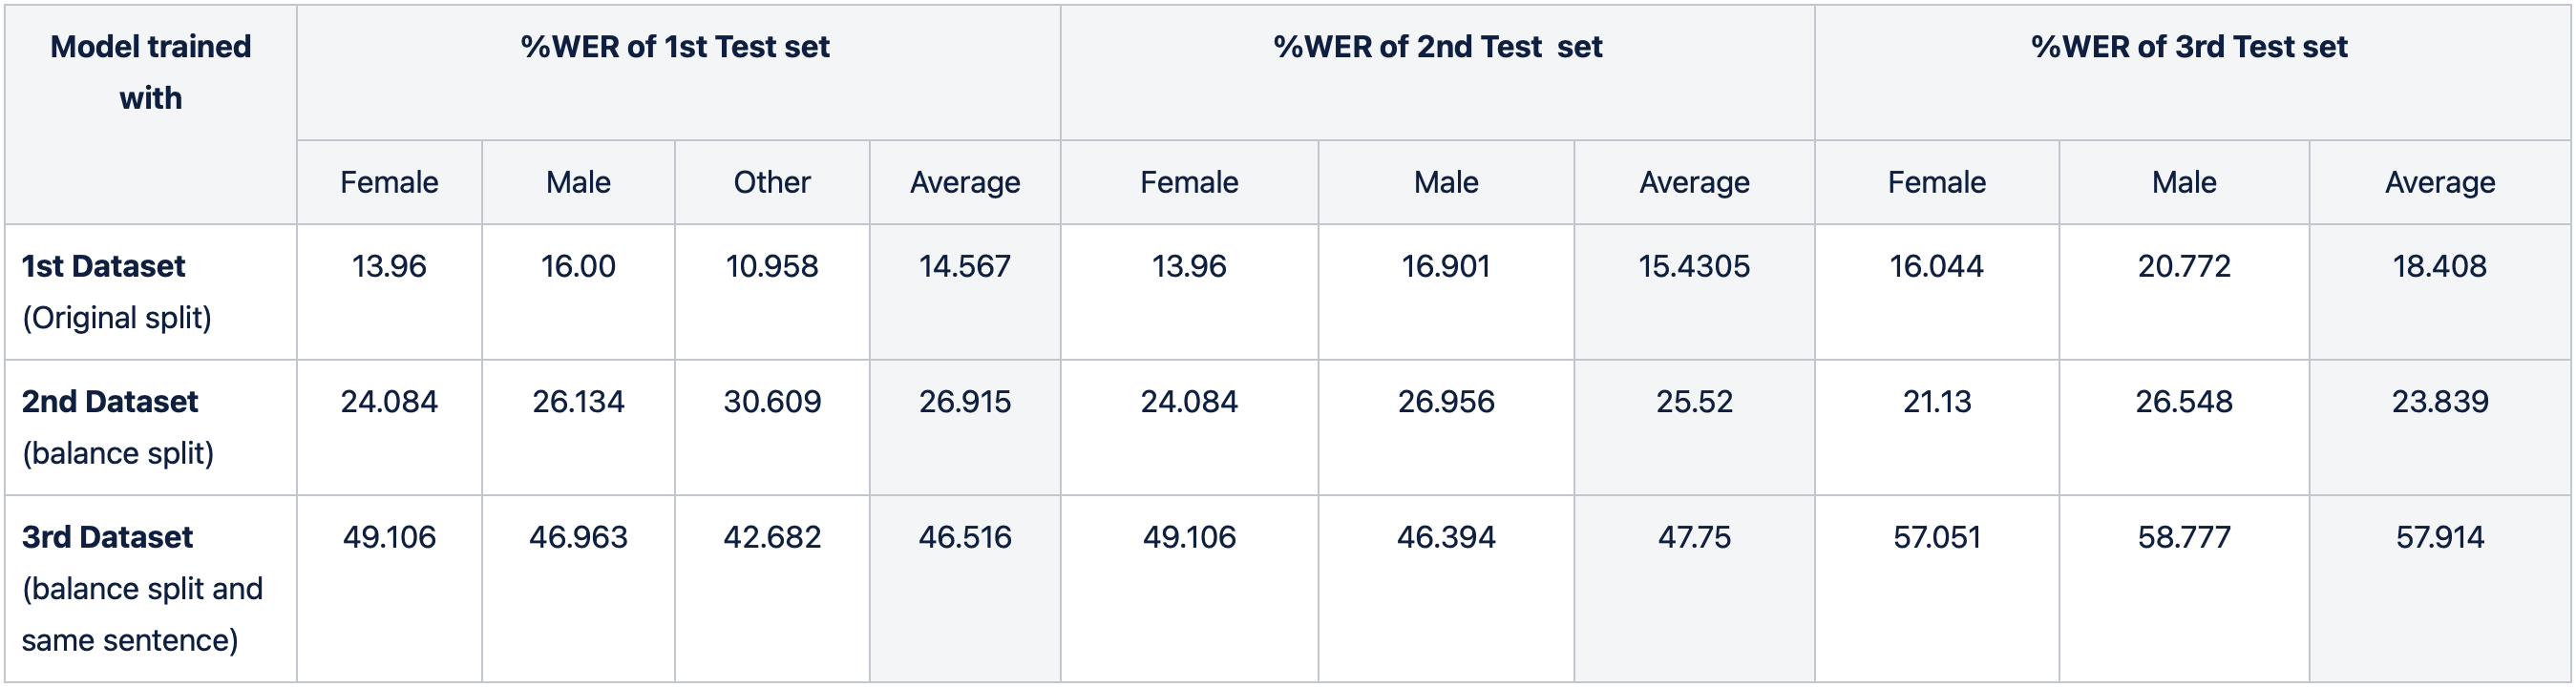

- After
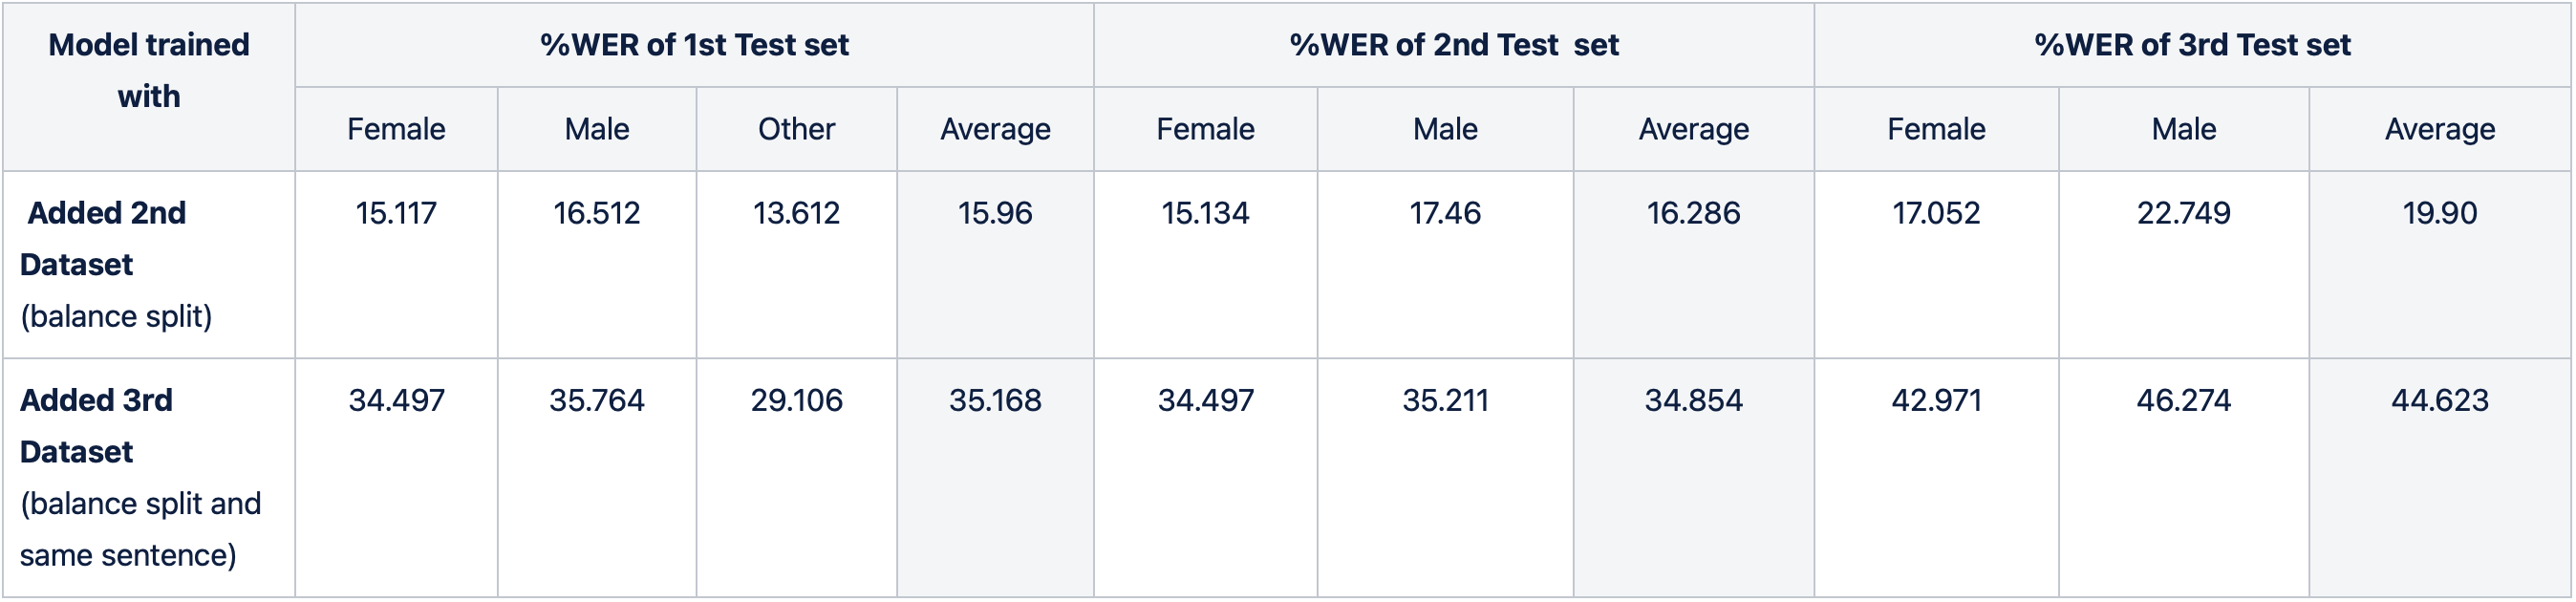

According to the reports, the overall performance is better with added training data. However, WER of females is still slightly less than males in 2 new models.

CER (character error rate)(%) Before and after upsampling with not_filling dataset
- Before
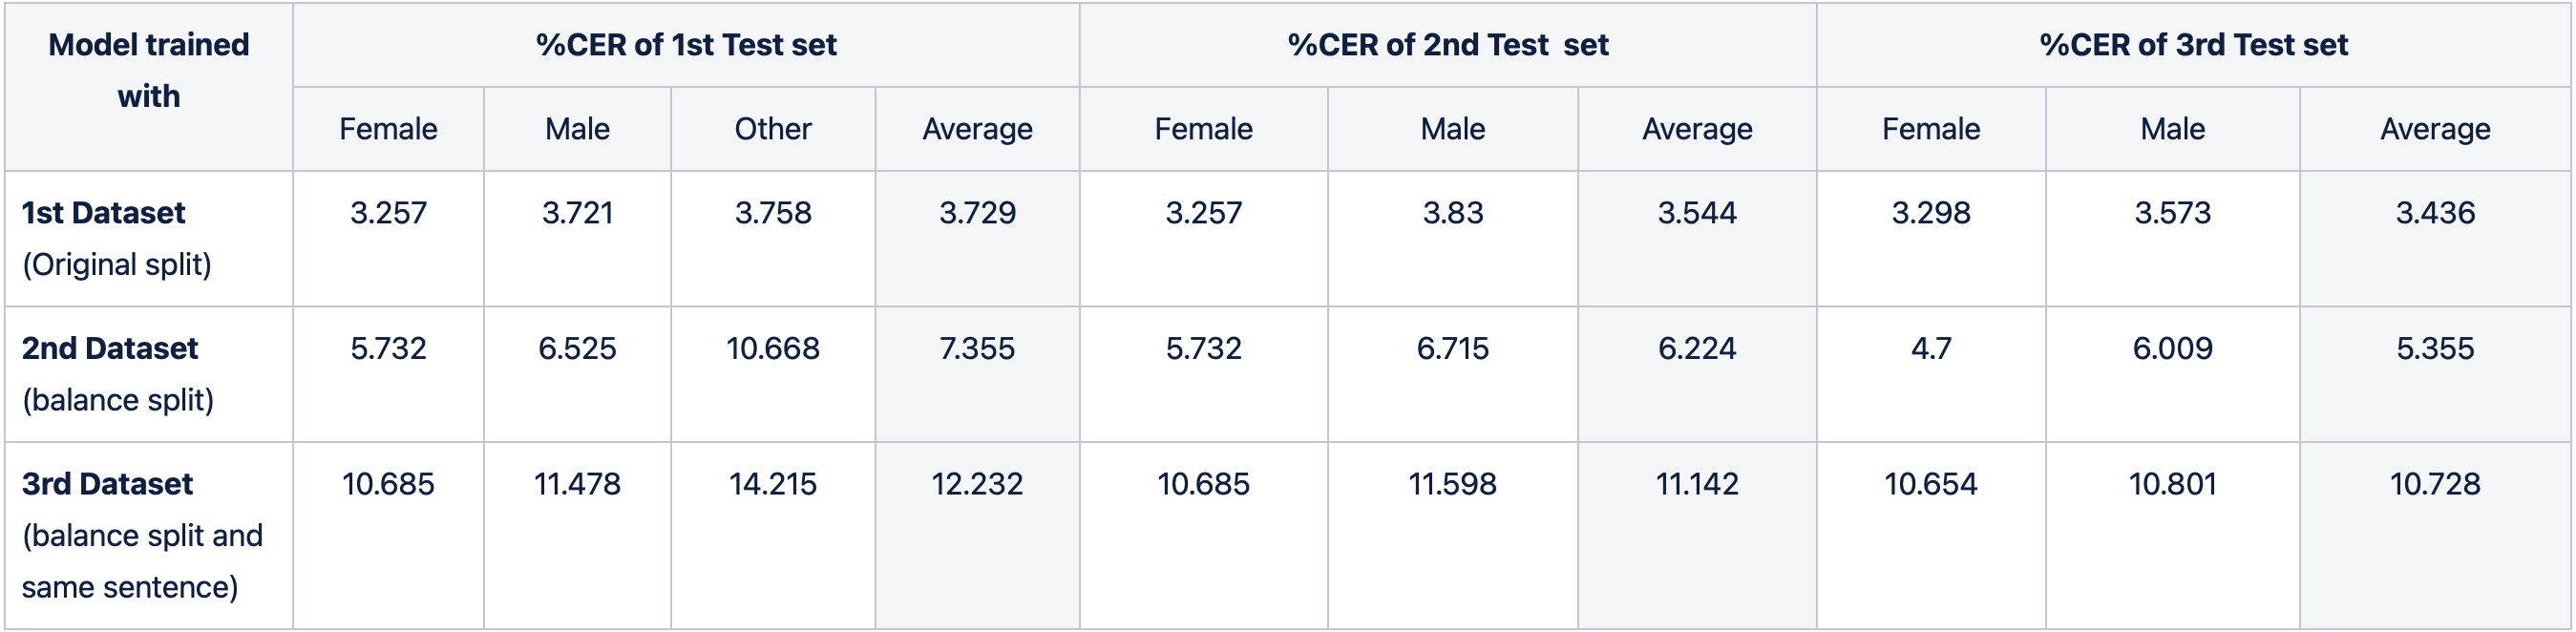

- After
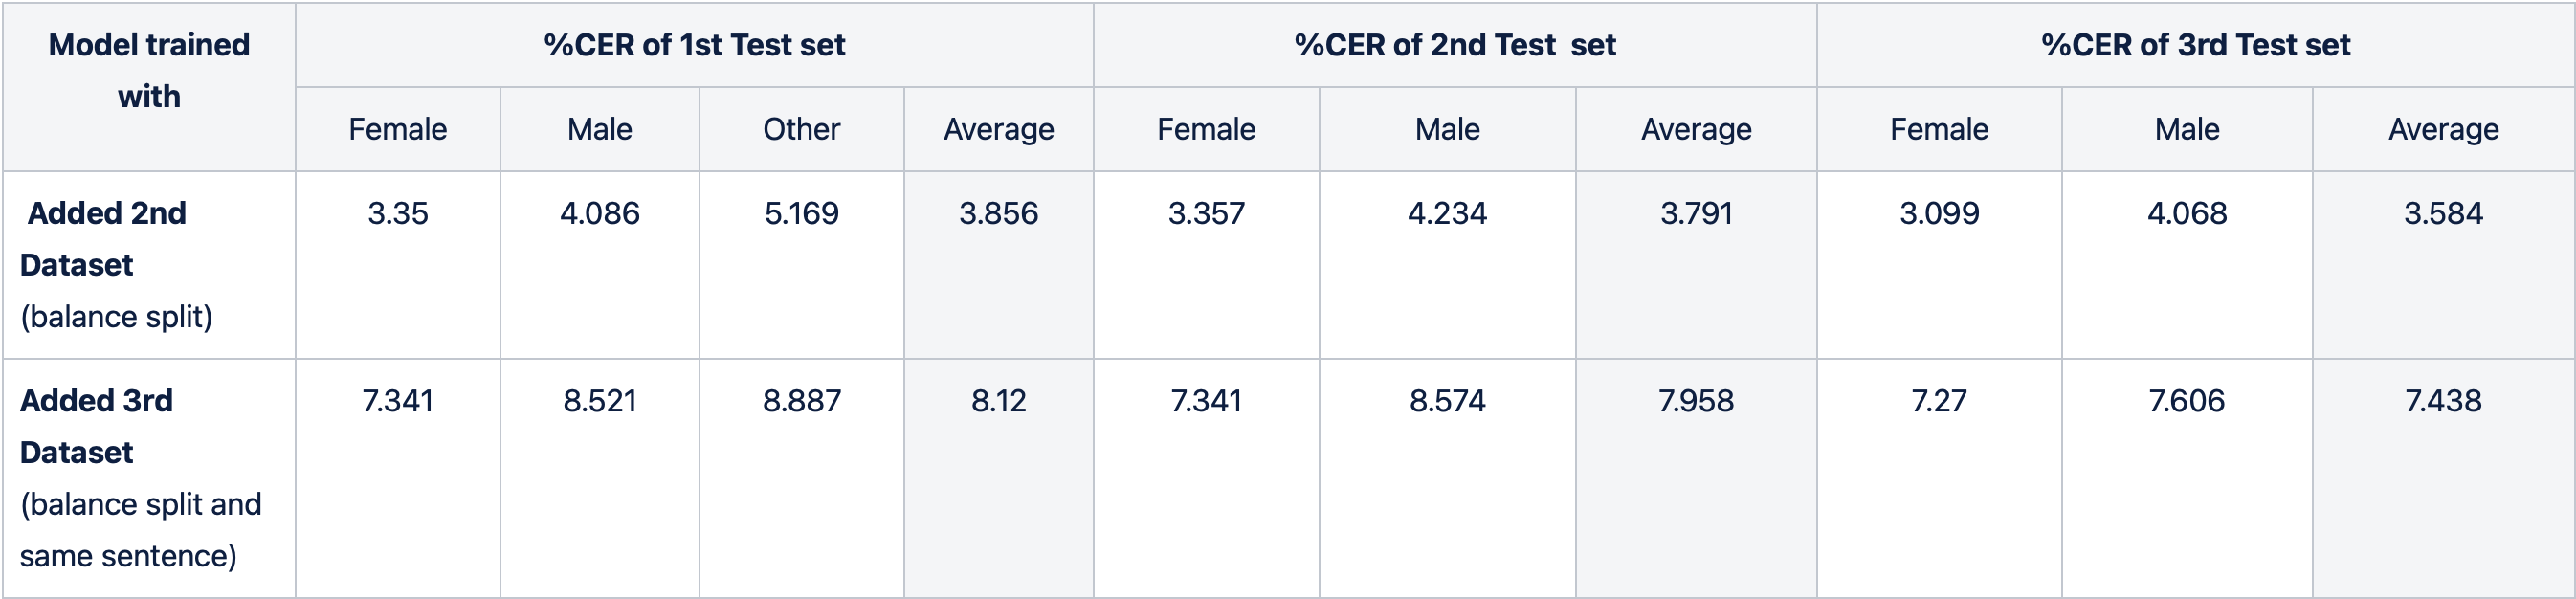

Like WER, performance of both new models was improved by looking at CER, but gender bias persisted.

After we trained models with greater and balance data by filling gender by gender classifiers above.

After we evaluated the model, We found our model may improve by using not-filling-gender data. So we build a gender classifier to allow us better handle the Bias

# 5. Further Analysis

You can see that our result in every data set did not have a bias between gender but we have the question? why did the data from males more than females give almost the same CER? So we have 5 assumptions.
1. Maybe the diversity of females is more than male. [1. Maybe there are more variety of female donating than male.]
2. Maybe female voice donation behaviour gives higher quality than male. [duration]
3. Maybe the sentence from males are short and have a word variation less than females. [Sentences spoken by female cover wider word variation than those of male.]
4. Maybe the male voice data have higher background noise than the female. [Clarity and quality.]
5. Maybe the male voice has some characteristics that can identify harder than the female voice characteristics.


In this work, We experiment to prove assumption 1-4 due to time limitation. By The result of proving are below.

### 5.1 Experiment for the first assumption

Let's explore the gender distribution of each dataset. Before apply result from gender classifier, we have only 516 male and 498 female speaker from totalof 6386 speaker (most of them aren't specific their gender). After we applied result from gender classifier we have 2803 male and 3583 female speakers. For number of samples, there are 76500 samples for male and 59193 samples for female.

In [52]:
df = pd.read_csv("data/annotation/validated.tsv", sep="\t")
df["client_id"].value_counts()[0:20]

/Users/kongpolc/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


765ddb5b81ef7881ddadd9c2d01f0a368270cf136bb40709cc54dfb0ac7b5eceb9992064a9c4cb70e976dd2345a1ddfd87701c3bdae4d2a41febb10d7303bbc9    25296
79e1c16f109709cef324603d132e0246ed7302f0c71f79a5f7da0513dc02a00e74a3d2506d7997f4fe681dba7fe3c9b783217271db4e7e60bbe79d11b1e81af0     9131
5c00cfb1fc9b0f86601d82194d83cfb940c3a25c8bc5167daf3f918498b3e39d2bf28cc234abeb7d12b98bb111c3521018023e4665ae4a4c9541ecd6b80d65ec     3705
4e9845ab38620c7f7816e360318bef2b93eb3adc1867d6b7f438c6fc9147fca96db584f524fd5b545f5641b281f4e2209b7fba9c7d2b7b79d07bb6b9d26a0fe2     3292
132b4f09f2e98682330263cbdc60038723baed274d48cc89edb6e96ed3aa4506933afac4fca8ee8f1fab3f170079c784b6d67bb8dbb0393ca02bddb0b7fc1578     2312
a67c2d857403fa07ae11ff6ca484fef466c68154234ae44651b422f89520a205dc5ad0f0382298470807ca92cff06cda37e437e17bf8e19a6141964bbb91fb95     2129
f6ea8fea0fb9947b878d2625f04a6b8f4e6a50577a907136f525367b2e4b6dcb0a14bb62e68d2e822868740a13a0ae11d43d85a632234e41a69819e8f616c1e7     2118
0bf48b2997faa1392615d12db5bf514ee0

In [53]:
df["client_id"].value_counts()[0:20].sum()

62281

There's something I want to points out here:
- Almost half of dataset are from only 20 person.
    From the image shows that almost half of the dataset are from only 20 person.
    
- 25,296 of male voices belong to a single donator.

### 5.2 Experiment for the second assumption

<b>Assumption:</b>

Majority of women donating voice in this dataset speak more meticulously and slowly than men.

<b>Experiment:</b>

Using the balanced dataset #3 - having similar sentences for male and female, find out the average speech duration and compare for each gender. The steps are as follow:

In [ ]:
!pip install torchaudio
!pip install pydub

In [54]:
import torchaudio
from pydub import AudioSegment
from tqdm import tqdm
import pandas as pd
import os

In [56]:
train = pd.read_csv('data/annotation/dataset_3/train.csv')
dev = pd.read_csv('data/annotation/dataset_3/dev.csv')
test = pd.read_csv('data/annotation/dataset_3/test.csv')

##### - Remove leading and trailing silence from clips.

In [58]:
def detect_leading_silence(speech, silence_threshold=-50.0, chunk_size=10):
    ''' Detect and trim silence by iterating over chunks until you find the first one with sound. '''
    
    trim_ms = 0
    assert chunk_size > 0
    while speech[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(speech):
        trim_ms += chunk_size

    return trim_ms

In [59]:
def trim_clip(df, path_to_clip, dest_path):
    ''' Trim and save as new clip. '''

    for i in tqdm(range(len(df))):
        filename = df['path'][i].replace('.mp3', '.wav')

        speech = AudioSegment.from_file(os.path.join(path_to_clip, filename), format="wav")

        start_trim = detect_leading_silence(speech)
        end_trim = detect_leading_silence(speech.reverse())

        duration = len(speech) 
        trimmed_speech = speech[start_trim:duration-end_trim]

        trimmed_speech.export(os.path.join(dest_path, filename), format="wav")

In [ ]:
path_to_clip = 'data/data/clips_wav'
dest_path = 'data/data/clips_wav_trimmed'
os.makedirs(dest_path, exist_ok=True)

trim_clip(train, path_to_clip, dest_path)
trim_clip(dev, path_to_clip, dest_path)
trim_clip(test, path_to_clip, dest_path)

See and compare the original vs. the trimmed clip

In [11]:
from IPython.display import Audio 

- Original vs. trimmed #1

In [18]:
Audio('data/data/clips_wav/common_voice_th_25691315.wav', autoplay=True)

In [20]:
Audio('data/data/clips_wav_trimmed/common_voice_th_25691315.wav', autoplay=True)

- Get speech duration of those processed clips.

In [62]:
def calculate_clip_duration(clip_path):
    ''' Calculates clip duration in second. '''
    try:
        speech, sr = torchaudio.load(clip_path)
        return speech.shape[-1]/sr
    except:
        return -1

In [ ]:
path_to_clip = 'data/data/clips_wav_trimmed'
train['duration'] = train['path'].apply(lambda x: calculate_clip_duration(os.path.join(path_to_clip, x.replace('.mp3','.wav'))))
dev['duration'] = dev['path'].apply(lambda x: calculate_clip_duration(os.path.join(path_to_clip, x.replace('.mp3','.wav'))))
test['duration'] = test['path'].apply(lambda x: calculate_clip_duration(os.path.join(path_to_clip, x.replace('.mp3','.wav'))))

In [74]:
train.to_csv('data/annotation/dataset_3/train_trimmed.csv', index=False)
dev.to_csv('data/annotation/dataset_3/dev_trimmed.csv', index=False)
test.to_csv('data/annotation/dataset_3/test_trimmed.csv', index=False)

- Find the average duration for male and female.

In [9]:
train.groupby(['gender'])['duration'].mean()

gender
female    2.921746
male      3.355542
Name: duration, dtype: float64

In [10]:
dev.groupby(['gender'])['duration'].mean()

gender
female    2.811568
male      3.327649
Name: duration, dtype: float64

In [8]:
test.groupby(['gender'])['duration'].mean()

gender
female    2.892000
male      3.214079
Name: duration, dtype: float64

<b>Result:</b>

The result demonstrates that the average speech duration of male is slightly longer than that of female which does not prove the assumption of this experiment. Therefore, individual samples are analysed further by comparing Character Error Rate (CER) and speech duration of same sentence spoken by male and female. It is done by mapping STT prediction, WER, and CER the corresponding record. The result is in `data/annotation/dataset_3/test_trimmed_with_cer.csv`. Some of the examples are shown below.

In [78]:
test_cer = pd.read_csv('data/annotation/dataset_3/test_trimmed_with_cer.csv')

Examples of male speech having higher CER with shorter speech duration

In [79]:
test_cer[test_cer['sentence']=='ชายแก่ได้ทิ้งหนังสือ'][['path','sentence','prediction','gender','wer','cer','duration']]

,path,sentence,prediction,gender,wer,cer,duration
146,common_voice_th_25942103.mp3,ชายแก่ได้ทิ้งหนังสือ,ชาย ใด ได้ที่ นัง สือ,male,0.8,0.3750,1.314
147,common_voice_th_25909030.mp3,ชายแก่ได้ทิ้งหนังสือ,ชาย แก่ ได้ คิง หนังสือ,female,0.2,0.0833,2.034


In [71]:
test_cer[test_cer['sentence']=='ด้วยความร่วมมือเราจะสามารถครอบครองโลกได้'][['path','sentence','prediction','gender','wer','cer','duration']]

,path,sentence,prediction,gender,wer,cer,duration
160,common_voice_th_25731152.mp3,ด้วยความร่วมมือเราจะสามารถครอบครองโลกได้,เดือย ความร่วมมือ แล้ วจะ สามารถ ข้อ คง รวก ได้,male,0.750,0.3191,2.612
161,common_voice_th_25731445.mp3,ด้วยความร่วมมือเราจะสามารถครอบครองโลกได้,เมื่อ ความร่วมมือ เรา จะ สามารถ ครอบ พร้อง โลก...,female,0.375,0.1702,3.576


Examples of male speech having higher CER with longer speech duration

In [72]:
test_cer[test_cer['sentence']=='ทรัสต์เพื่อการลงทุนในอสังหาริมทรัพย์'][['path','sentence','prediction','gender','wer','cer','duration']]

,path,sentence,prediction,gender,wer,cer,duration
182,common_voice_th_26168755.mp3,ทรัสต์เพื่อการลงทุนในอสังหาริมทรัพย์,ทรัสต์ เพื่อ การ ลง ทน ใน อสังหาริม ศัพท์,male,1.0,0.15,3.584
183,common_voice_th_26096197.mp3,ทรัสต์เพื่อการลงทุนในอสังหาริมทรัพย์,ทรัสต์ เพื่อ การลงทุน ใน อสังหาริมทรัพย์,female,0.0,0.00,2.940


In [73]:
test_cer[test_cer['sentence']=='บนเพดานของห้องส่วนใหญ่ยังคงไม่บุบสลาย แต่ก็ยังเห็นร่องรอยจากความชื้น'][['path','sentence','prediction','gender','wer','cer','duration']]

,path,sentence,prediction,gender,wer,cer,duration
214,common_voice_th_25897916.mp3,บนเพดานของห้องส่วนใหญ่ยังคงไม่บุบสลาย แต่ก็ยัง...,บน เพดาน ของ ห้อง ส่วนใหญ่ ยังคง ไม่ ห อู กส น...,male,0.4,0.1605,6.806
215,common_voice_th_25916477.mp3,บนเพดานของห้องส่วนใหญ่ยังคงไม่บุบสลาย แต่ก็ยัง...,บน พ ยา ดาน ของ ห้อง ส่วนใหญ่ ยังคง ไม่ บุ ค ส...,female,0.4,0.0988,6.078


This shows that CER and speech duration are not correlated. Many instances show a decrease in CER with longer speech duration while many also show an increase in CER with longer speech duration. Hence, disproving the assumption of this experiment.

### 5.3 Experiment For The Third Assumption

**Assumption:**

Maybe the sentence from males are shorter and have a word variation less than females.

**Expermient:**

We used the Bag of Word method and the Number of Tokenizers of each sentence for analyzing.

In [ ]:
!pip install pythainlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import essential libraries
import pandas as pd
from glob import glob
from pythainlp.tokenize import word_tokenize

In [ ]:
#get all file name
files = glob("added_gender_data/*")

In [ ]:
# getting token number in each sentence
for file in files:
    df_temp = pd.read_excel(file)
    
    temp_tokenized_word = []
    no_tokens = []
    for i in range(0, len(df_temp)):
        w = word_tokenize(df_temp["sentence"][i], engine="newmm")
        temp_tokenized_word.append(w)
        no_tokens.append(len(w))
        
    df_temp["tokenized"] = temp_tokenized_word
    df_temp["no_tokens"] = no_tokens
    
    df_temp.to_excel(file)    

In [ ]:
print(df_temp.describe())

        Unnamed: 0   Unnamed: 0.1    up_votes  down_votes  accents  \
count   148.000000     148.000000  148.000000  148.000000      0.0   
mean   3781.202703   89083.500000    2.027027    0.081081      NaN   
std    2007.419808   28323.368132    0.162713    0.273886      NaN   
min      85.000000      76.000000    2.000000    0.000000      NaN   
25%    2326.250000   72954.500000    2.000000    0.000000      NaN   
50%    3877.000000   95149.000000    2.000000    0.000000      NaN   
75%    5617.750000  111189.500000    2.000000    0.000000      NaN   
max    6789.000000  131985.000000    3.000000    1.000000      NaN   

          weights   no_tokens  
count  148.000000  148.000000  
mean     0.305570    6.675676  
std      0.083013    3.456663  
min      0.222838    1.000000  
25%      0.222838    5.000000  
50%      0.305570    6.000000  
75%      0.388301    9.000000  
max      0.388301   15.000000  


In [ ]:
# Get Bag of Word, Grupby gender
import pandas as pd
import numpy as np
import collections
from tqdm import tqdm

# Define function and parameter
def calculateBOW(wordset,l_doc):
    tf_diz = dict.fromkeys(wordset,0)
    for word in l_doc:
        tf_diz[word]=l_doc.count(word)
    return tf_diz

bow_m = []
bow_f = []
word_sets_m = []
word_sets_f = []
docs = []
for file in files:
    df_temp = pd.read_excel(file)
    df_male = df_temp[df_temp["gender"]=="male"]
    df_male.reset_index(inplace = True, drop=True)
    df_female = df_temp[df_temp["gender"]=="female"]
    df_female.reset_index(inplace = True, drop=True)

    temp_tokenized_word_m = []
    word_set_m = []
    for i in range(0, len(df_male)):
        w = word_tokenize(df_male["sentence"][i], engine="newmm")
        for token in w:
            temp_tokenized_word_m.append(token)
    word_set_m = word_set_m + temp_tokenized_word_m #collect all word
    bow_m.append(temp_tokenized_word_m) #collect all word of each file

    temp_tokenized_word_f = []

    word_set_f = []
    for i in range(0, len(df_female)):
        w = word_tokenize(df_female["sentence"][i], engine="newmm")
        for token in w:
            temp_tokenized_word_f.append(token)
    word_set_f = word_set_f + temp_tokenized_word_f #collect all word
    bow_f.append(temp_tokenized_word_f) #collect all word of each file

    docs.append(file.split("/")[1]) #collect file name of each bow

    word_sets_m.append(word_set_m)
    word_sets_f.append(word_set_f)



In [ ]:
# call get BOW function
df_bows_m = []
df_bows_f = []
for i in tqdm(range(0, len(files))):
    bow_m_dict= calculateBOW(word_sets_m[i], bow_m[i] )
    bow_f_dict = calculateBOW(word_sets_f[i], bow_f[i] )
    
    df_bows_m.append(pd.DataFrame(bow_m_dict, index=[i]))
    df_bows_f.append(pd.DataFrame(bow_f_dict, index=[i]))


100%|██████████| 9/9 [9:59:45<00:00, 3998.36s/it]


In [ ]:
# Export file
df_m = pd.concat(df_bows_m)
df_m["file"] = docs
df_m = df_m.T
# print(df_m)
df_f = pd.concat(df_bows_f)
df_f["file"] = docs
df_f = df_f.T
# print(df_f)

writer = pd.ExcelWriter("bow_analysis/bow_analysis.xlsx", engine = 'xlsxwriter')
df_m.to_excel(writer, sheet_name = 'male')
df_f.to_excel(writer, sheet_name = 'female')

writer.save()
writer.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys
/usr/local/lib/python3.7/dist-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


**Result** 

As we analyze the number of words in each sentence and the Bag of words of added data in excel file, We found the number of words in sentences from the male and female sentences is not quite different. But in the word variation, males have a variation of words more than females.

Result: Word frequency of each sentence
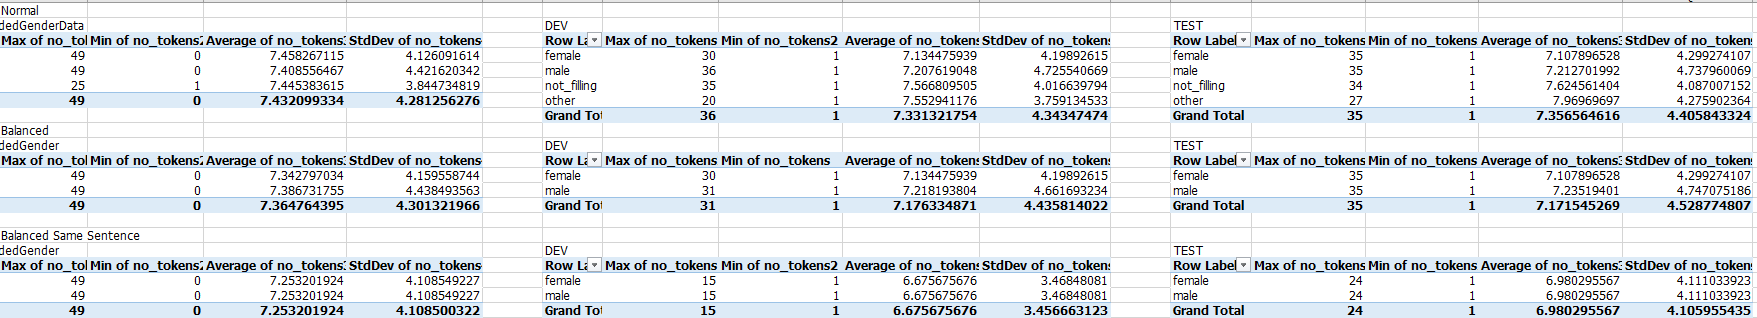

Result: Bag of Word (Frequency of unique words in each data)
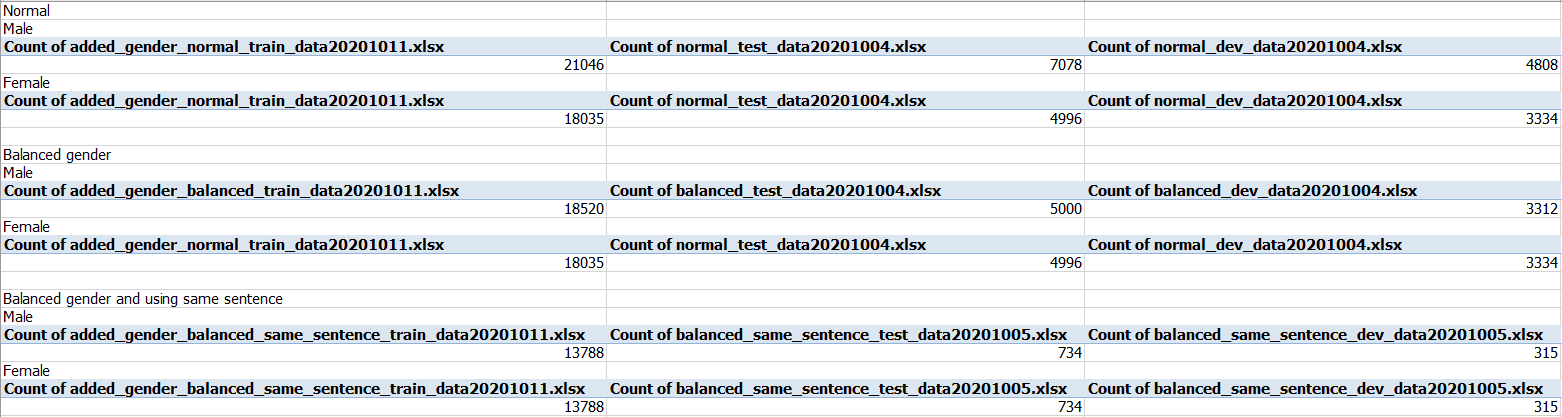

### 5.4 Experiment For the Fourth Assumption

**Assumption:** 

We assumed that there may be background noise in male data more than those found in female. 

**Experiment:**

We selected some files from the two genders, about 200 for each set of data, and listened to them file by file. 

**Result:**

We found that there was background noise in male data more than female. However, the background noise does not overpower the speech. Significantly, the majority of male data having background noises came from one ID and this ID donated his voice about one-third of male data. Moreover, the interesting points we found while listening to the data was that females seemed to speak slower and clearer than males. Males sometimes rushed their words. As a result, this could be one reason why the model can recognize female voice better than male voice although the dataset is one fourth smaller than male dataset.

# 6. Conclusion

In our experiment, we focused on the gender bias in common voice 11 dataset as the distribution of gender-labeled data is not equal. The amount of female-labeled data is much smaller than that of male-labeled data. After we trained the model with common voice 11 data, it showed that the model could better recognize the female voice in most cases of our experiments even though the female-labeled data was about one fourth smaller when compared to male-labeled data. We tried to find out why model was good for females rather than males and found that the reason might come from the quality of data and the amount of people donating their voice rather than quantity of data. It seemed that the more people donated, the more variation of voice or knowledge model can learn. We applied our gender classification model to identify gender for “not filling” class. The accuracy of our gender classification model achieved 94% for F1 score on our test set. The results suggested that the number of women donating their voice is much more than men, 3,583 and 2,803 respectively while the number of files of female dataset is about one-fourth smaller than male dataset, 76,500 and 59,193 respectively. Therefore, this led to the conclusion that the various voices are very significant and important than the quantity. Although the size of data is large but the source of data comes from few people, the model does not learn well and may not improve much.

# 7. Future work

Since we have learned that the number of various voices is important, we plan to not include all amount of data of the one who donated much more data than others but try to balance the dataset for training data. Moreover, we assumed that male voice tends to have some characteristics like low-pitched voice that are harder for model to recognize than female voice. We may use some tools to estimate the fundamental frequency (F0) of each voice as F0 is related to pitch and then do the experiment from the training data grouped by F0.